# Построение рекомендательной системы курсов и анализ ее эффективности с помощью A/B тестирования для обучающей онлайн платформы SkillFactory 



# Оглавление 
- [1. Построение рекомендательной системы курсов](#1)
    - [1.1 Получение, исследование и предобработка данных](#1.1)
        - [1.1.1 Описание схемы данных](#1.1)
        - [1.1.2 Получение данных для анализа](#1.1.2)
    - [1.2 Обработка данных](#1.2)
    - [1.3 Вывод результата и итоги](#1.3)
- [2. A/B тестирование](#2)
    - [2.1 Описание, ход работы и обработка результатов эксперимента](#2)
    - [2.2 Результат A/B тестирования](#2.2)



# 1. Построение рекомендательной системы курсов
<a id='1'></a>

<b>Цель проекта</b>: 

В ходе предварительного исследования обучающей платформы Skillfactory было обнаружено, что большинство пользователей покупают один и тот же популярный курс по изучению языка программирования Python для новичков, не замечая при этом остальные курсы, представленные на платформе.

Для повышения среднего чека корзины и продвижения остальных курсов было принято решение реализовать новую функциональность с предложением добавить в корзину второй подходящий курс, который мог бы быть интересен  пользователю. 

Задачей этого проекта является построение рекомендательной системы курсов, благодаря которой можно будет предлагать клиентам подходящие курсы и вывод таблицы с рекомендациями для каждого курса, а также проведение и анализ A/B тестирования после запуска новой функции.

Построенная в этом проекте рекомендательная система послужит основой для разработки функции по допродаже курсов в корзине. 


In [1]:
# Импорт библиотек
import pandas as pd 
import psycopg2
import psycopg2.extras 
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from scipy.stats import norm
from scipy.stats import t
from scipy import stats
import math 
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

<a id='1.1'></a>
## 1.1 Получение, исследование и предобработка данных

### 1.1.1 Описание схемы данных

Посмотрим доступные нам таблицы в дериктории final. 

In [2]:
def getTables():
    query = '''
    select t.table_schema, t.table_name from information_schema.tables t where t.table_schema = 'final'
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432") # данные для подключения к БД удалены в целях безопасности
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data



df_tables = pd.DataFrame(getTables())
df_tables





,table_schema,table_name
0,final,cart_items
1,final,carts


In [3]:
def getCarts():
    query = '''
    select * from final.carts
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432") # данные для подключения к БД удалены в целях безопасности
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data



df_carts = pd.DataFrame(getCarts())
df_carts






,id,created_at,updated_at,purchased_at,state,user_id,promo_code_id
0,230789,2017-01-19 07:50:41.298,2017-01-19 07:52:08.586,2017-01-19 07:52:08.590,successful,1010882,NaN
1,189760,2016-10-24 15:49:18.112,2017-01-11 12:20:13.396,2017-01-11 12:20:13.399,successful,906674,NaN
2,258743,2017-04-03 09:03:37.633,2017-06-15 18:31:46.573,2017-06-15 18:31:46.577,successful,160494,3548100.0
3,258697,2017-04-03 06:43:01.151,2017-04-11 16:18:22.876,2017-04-11 16:18:22.879,successful,1084654,NaN
4,230716,2017-01-18 22:50:51.644,2017-01-18 22:54:15.896,2017-01-18 22:54:15.901,successful,749529,NaN
...,...,...,...,...,...,...,...
93108,336815,2017-09-21 15:56:33.645,2017-09-21 15:56:40.596,NaT,pending,1259665,NaN
93109,336839,2017-09-21 16:12:13.053,2017-09-21 16:12:28.890,NaT,pending,1259804,NaN
93110,324068,2017-09-09 05:08:40.503,2017-09-21 16:19:22.585,NaT,pending,170214,NaN
93111,336843,2017-09-21 16:14:09.374,2017-09-21 16:17:00.603,2017-09-21 16:17:00.605,successful,1164493,NaN


In [4]:
def getItems():
    query = '''
    select * from final.cart_items
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432") # данные для подключения к БД удалены в целях безопасности
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data



df_items = pd.DataFrame(getItems())
df_items





,id,cart_id,created_at,updated_at,resource_type,resource_id
0,522159,230789,2017-01-19 07:50:41.313,2017-01-19 07:50:41.313,Course,490
1,460355,189760,2016-10-24 15:49:18.127,2016-10-24 15:49:18.127,Course,357
2,575400,258743,2017-04-03 09:05:18.837,2017-04-03 09:05:18.837,Course,507
3,575619,258697,2017-04-03 14:00:18.830,2017-04-03 14:00:18.830,Course,514
4,522058,230716,2017-01-18 22:50:51.658,2017-01-18 22:50:51.658,Course,489
...,...,...,...,...,...,...
100234,725018,336815,2017-09-21 15:56:33.740,2017-09-21 15:56:33.740,Course,566
100235,725045,336839,2017-09-21 16:12:13.197,2017-09-21 16:12:13.197,Course,745
100236,725048,324068,2017-09-21 16:13:29.846,2017-09-21 16:13:29.846,Course,672
100237,725050,336843,2017-09-21 16:14:09.467,2017-09-21 16:14:09.467,Course,513


Опишем данныые:

<b>Таблица carts - список всех корзин пользователей</b>
* created_at - дата создания корзины (дата добавления первого товара в текущую корзину) 
* id  - id корзины
* promo_code_id  - промокод 
* purchased_at  - дата покупки товаров в корзине
* state  - статус корзины 
* updated_at  - дата последнего обновления корзины  
* user_id  - id пользователя добавившего товары в корзину 

<b>Таблица cart_items - список всех товаров добавленных в корзины пользователей</b>
* cart_id  - id корзины в которую добавлена товар 
* created_at  - дата добавления товара в корзину
* id  - ид товара в корзине
* resource_id  - ид самого товара 
* resource_type - тип товара 
* updated_at  - дата последнего обновления товара в корзине 


<a id='1.1.2'></a>
### 1.1.2 Получение данных для анализа

Узнаем, какие бывают типы товаров и статусы корзин. 


In [5]:
print(df_carts['state'].unique())
print(df_items['resource_type'].unique())



['successful' 'created' 'pending']
['Course' 'Product']


Так как нам нужны данные по всем продажам курсов, то тип товара будет Course, а статус корзины successful. 

<b>Задача:</b> Для построения рекомендательной системы необходимо определить, какие другие курсы чаще всего покупаются вместе с конкретным курсом (необязательно в рамках одной корзины). Для этого можно ранжировать все курсы и взять только те, что с наибольшей вероятностью заинтересуют клиентов. Мы предполагаем, что это позволит увеличить конверсию в покупку второго курса и увеличит доход. Если эта гипотеза подтвердится, то это также поможет в продвижении не самых популярных и известных в общем курсов. 

Для этого сначала выгрузим данные по всем продажам курсов в разрезе пользователей. 

In [6]:

def getData():
    query = '''select 
    c.user_id as user_id,
    ci.resource_id as course_id,
    ci.id as item_id,
    c.id as cart_id,
    c.purchased_at as cart_purchased_date,
    c.state
from
    final.carts c
    left join final.cart_items ci on ci.cart_id = c.id 
where ci.resource_type = 'Course'
order by c.user_id, ci.resource_id, ci.id
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432") # данные для подключения к БД удалены в целях безопасности
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

df = pd.DataFrame(getData())

# Сохраним список всех курсов
all_courses = df['course_id'].unique()
# Оставим только те строки, где покупка успешно состоялась
# (Такую фильтрацию я не стала делать в sql коде, чтобы сохранить данные о некупленных курсах)
df = df[df['state']=='successful']
df = df[['user_id', 'course_id', 'item_id', 'cart_id', 'cart_purchased_date']]
df



,user_id,course_id,item_id,cart_id,cart_purchased_date
0,51,516,483391,205876,2017-01-06 21:31:53.507
1,51,1099,941390,475936,2018-06-22 17:20:49.080
2,974,356,959818,487630,2018-08-01 13:43:48.380
4,2233,1125,979038,562850,2018-09-04 07:56:37.928
6,2581,1187,1082491,952515,2018-12-06 10:11:26.071
...,...,...,...,...,...
97167,2190509,742,1105840,966801,2018-12-29 20:27:18.617
97168,2190575,757,1105929,966841,2018-12-30 03:43:25.128
97169,2190589,1125,1105951,966846,2018-12-30 05:06:03.664
97172,2190991,489,1106561,967158,2018-12-30 17:13:36.973


In [7]:
print('Количество всех курсов:', len(all_courses))
print('Количество курсов, которые хотя бы раз продали:', df['course_id'].nunique())



Количество всех курсов: 127
Количество курсов, которые хотя бы раз продали: 126


Как видим один курс ни разу не продали, но рекомендацию для него дать тоже надо. Позже мы вернемся к этому списку. 



In [8]:
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 70581 entries, 0 to 97173
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              70581 non-null  int64         
 1   course_id            70581 non-null  int64         
 2   item_id              70581 non-null  int64         
 3   cart_id              70581 non-null  int64         
 4   cart_purchased_date  70581 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.2 MB


Формат данных правильный, пропусков нет.

Проверим нет ли дубликатов у id товара в корзине item_id, они должны быть уникальными. 
Также в проверке на уникальность нуждаются пара user_id - course_id, потому что если у этой пары есть дубликаты, то от них необзодимо избавиться, так как в случае, если у одного пользователя есть несколько одинаковых купленных курсов, это исказит результаты анализа, потому что такие пользователи могут покупать несколько одинаковых курсов ради благотворительности. 

In [9]:
print(df['item_id'].value_counts().mean())
print(df[['user_id', 'course_id']].value_counts().mean())


1.0
1.0022293536294444


У item_id дубликатов нет, а вот так как среднее количество повторений каждой пары больше 1, значит у пары user_id - course_id есть повторения, необходимо избавиться от лишних: 

In [10]:
df.drop_duplicates(subset = ['user_id', 'course_id'], keep = 'first', inplace = True)
print(df[['user_id', 'course_id']].value_counts().mean())



1.0


Теперь все ок, дубликатов нет. 

Так как в рамках одного пользователя нам нужно определить какие другие курсы чаще всего покупаются вместе с конкретным курсом, то, очевидно, что нам нужны только те пользователи, которые покупали больше одного курса, оставим только таких:



In [11]:
CC_df = df.groupby('user_id')['course_id'].count().reset_index().rename(columns={'course_id':'courses_count'})
users_with_more_than_one_courses = CC_df[CC_df['courses_count']>1]['user_id']
df = df[df['user_id'].isin(users_with_more_than_one_courses)]
df



,user_id,course_id,item_id,cart_id,cart_purchased_date
0,51,516,483391,205876,2017-01-06 21:31:53.507
1,51,1099,941390,475936,2018-06-22 17:20:49.080
14,6117,356,649689,295889,2017-06-30 17:36:47.875
15,6117,357,649871,295889,2017-06-30 17:36:47.875
16,6117,1125,959652,487524,2018-08-01 05:01:45.031
...,...,...,...,...,...
97137,2188926,515,1104017,965744,2018-12-29 12:13:35.994
97138,2188926,743,1103643,965744,2018-12-29 12:13:35.994
97162,2190141,756,1105383,966525,2018-12-29 13:21:55.093
97163,2190141,794,1105316,966525,2018-12-29 13:21:55.093


Все готово для анализа - типы данных в порядке, дубликаты удалены, лишние пользователи тоже удалены. 



<a id='1.2'></a>
## 1.2 Обработка данных

Итак, мы получили таблицу с данными по продажам курсов в разрезе пользователей (по купившим больше одного курса).

<b>Задача: </b> Составить таблицу с тремя столбцами:
- Курс, к которому идёт рекомендация.
- Курс для рекомендации № 1 (самый популярный).
- Курс для рекомендации № 2 (второй по популярности).





На этом этапе нужно разбить все покупки курсов на пары, после чего ранжировать их для каждого курса относительно количества покупок такой пары. 

In [12]:


courses_couples_list = [] # Создаем пустой список для хранения всех возможных пар курсов, которые покупали пользователи

for user in users_with_more_than_one_courses: # cначала проходимся по пользователям, чтобы определять пары в разрезе каждого пользователя
    for course in itertools.combinations(df[df['user_id']==user]['course_id'], 2): # проходимя по всем курсам конкретного пользователя и определяем все возможные пары курсов 
        courses_couples_list.append(course) # каждую пару курсов записываем в словарь

courses_couples_count_dict = dict(collections.Counter(courses_couples_list)) # считаем сколько раз повторяется каждый курс, записываем результат в словарь
courses_couples_count_list = list(courses_couples_count_dict.items()) # Создаем список со списком кортежей ("ключ", "значение") нашего словаря с количеством повторений каждого курса 
courses_couples_count_list.sort(key=lambda i: i[1], reverse=True) # и отсортируем его по второму элементу пары, то есть по значению (количеству повторений этой пары)
courses_couples_count_dict = dict(courses_couples_count_list)  # словарь с отсортированным по убыванию количеством повторений пары курсов



Получили словарь со всеми возможными парами курсов, которые были куплены вместе, и количеством их покупок.



In [13]:
# Создаем датафрейм (пара курсов - количество покупок таких пар) на основе получившегося словаря 
courses_couples_count_df = pd.DataFrame.from_dict(courses_couples_count_dict,'index').reset_index().rename(columns={'index':'couples', 0:'count'})
courses_couples_count_df



,couples,count
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
...,...,...
3984,"(741, 791)",1
3985,"(361, 1128)",1
3986,"(743, 1156)",1
3987,"(864, 1129)",1


Добавим отдельные столбцы для первой пары курса и второй пары курса:

In [14]:
for i in courses_couples_count_df.index: # проходимя по индексам датафрейма и в каждую строчку таблицы добавляем сначала столбец с первой парой курса, потом со втором парой курса
    courses_couples_count_df.loc[i, 'one'] = courses_couples_count_df.loc[i, 'couples'][0]
    courses_couples_count_df.loc[i, 'two'] = courses_couples_count_df.loc[i, 'couples'][1]

courses_couples_count_df

,couples,count,one,two
0,"(551, 566)",797,551.0,566.0
1,"(515, 551)",417,515.0,551.0
2,"(489, 551)",311,489.0,551.0
3,"(523, 551)",304,523.0,551.0
4,"(566, 794)",290,566.0,794.0
...,...,...,...,...
3984,"(741, 791)",1,741.0,791.0
3985,"(361, 1128)",1,361.0,1128.0
3986,"(743, 1156)",1,743.0,1156.0
3987,"(864, 1129)",1,864.0,1129.0


Сконструируем таблицу так, чтобы для каждого курса в соответствие был проставлен рекомендованный курс (пока у каждого курса может быть много рекомендаций) и количество покупок такой пары. 

В таблице courses_couples_count_df представлены только уникальные пары курсов, а нам нужна такая таблица, где для каждого курса будет представлена своя пара-рекомендация.

Например, у нас есть уникальная пара курсов (А, Б), которую купили например n раз. 
Получается, что курс А купили n раз в паре с курсом Б, и наоборот курс Б купили n раз в паре с курсом А. 
Таким образом, необходимо создать дубликаты для каждой уникальной пары, которые будут отличаться только лишь тем, что в первом случае основным курсом будет курс А (а парой-рекомендацией будет курс Б), а во втором случае основным курсом будет курс Б (а парой-рекомендацией будет курс А).

In [15]:
# Сначала создадим два отдельных датафрейма с одной из пар курсов 
one_df = courses_couples_count_df[['couples', 'count', 'one']]
two_df = courses_couples_count_df[['couples', 'count', 'two']]

# после чего эти две таблицы нужно склеить одну за другой. Для этого необходимо, чтобы все столбцы этих двух таблиц имели одинаковое название
one_df = courses_couples_count_df.rename(columns={'one':'course_id', 'two':'recommendation'})
two_df = courses_couples_count_df.rename(columns={'one':'recommendation', 'two':'course_id'})
my_df = one_df.append(two_df, sort = False, ignore_index=True) # склеиваем таблицы и получаем результат, где для каждого курса представлена рекомендация другого курса, которую покупали какое-то количество раз в паре с этим курсом. 
my_df = my_df.sort_values(['course_id','count'], ascending=False)[['course_id', 'recommendation', 'count']] # отсортируем курс по айди курса и количеству покупок его с той или иной парой в порядке убывания, а также оставим только нужные столбцы
my_df



,course_id,recommendation,count
7030,1201.0,571.0,1
7031,1201.0,1144.0,1
7032,1201.0,1186.0,1
7140,1201.0,1125.0,1
7217,1200.0,866.0,1
...,...,...,...
3734,356.0,503.0,1
3735,356.0,742.0,1
3768,356.0,835.0,1
3895,356.0,1102.0,1


Теперь проранжируем пары курсов в разрезе каждого курса в зависимости от количества покупок этой пары.

Для этого можно сгруппировать таблицу по course_id, взять количество покупок count и воспользоваться методом rank, который пронумерует каждую пару в разрезе course_id и в зависимости от count в порядке убывания (чем больше количество покупок, тем меньше ранг). При этом для одинакового количества покупок ранг будет тоже одинаковым. 

In [16]:
# Получаем ранг для каждой пары курсов, получается таблица с индексом строки и номером ранга
rank_df = my_df.groupby('course_id')['count'].rank(method='dense', ascending=False).reset_index().rename(columns={'count':'rank'})
rank_df




,index,rank
0,7030,1.0
1,7031,1.0
2,7032,1.0
3,7140,1.0
4,7217,1.0
...,...,...
7973,3734,25.0
7974,3735,25.0
7975,3768,25.0
7976,3895,25.0


Соединим нашу основную таблицу my_df с таблицей рангов. Ключем будет индекс.

В итоге получим таблицу, в которой каждая пара Основной курс - Рекомендация проранжирована в зависимости от количества покупок в разрезе каждого курса. 



In [17]:
my_df = my_df.reset_index().merge(rank_df, how='inner', on='index')
my_df = my_df[['course_id', 'recommendation', 'count', 'rank']]
my_df



,course_id,recommendation,count,rank
0,1201.0,571.0,1,1.0
1,1201.0,1144.0,1,1.0
2,1201.0,1186.0,1,1.0
3,1201.0,1125.0,1,1.0
4,1200.0,866.0,1,1.0
...,...,...,...,...
7973,356.0,503.0,1,25.0
7974,356.0,742.0,1,25.0
7975,356.0,835.0,1,25.0
7976,356.0,1102.0,1,25.0


Для каждого курса необходимо составить по две рекомендации (самый популярный курс и второй по популярности). 

Поэтому из получившейся таблицы уберем ненужные пары курсов, то есть оставим только те, у которых ранг равен 1 и 2:

In [18]:
my_df = my_df[(my_df['rank']==1) | (my_df['rank']==2)]
my_df


,course_id,recommendation,count,rank
0,1201.0,571.0,1,1.0
1,1201.0,1144.0,1,1.0
2,1201.0,1186.0,1,1.0
3,1201.0,1125.0,1,1.0
4,1200.0,866.0,1,1.0
...,...,...,...,...
7797,358.0,752.0,19,2.0
7833,357.0,571.0,112,1.0
7834,357.0,356.0,100,2.0
7904,356.0,571.0,103,1.0


Мы видим, что есть рекомендации к курсам, которые встречаются только один раз. Было бы нецелесообразно рекомендовать пользователям курсы, основанные на небольшом количестве соответствующих покупок, следовательно, необходимо установить минимальную границу количества покупок - какое количество считать слишком малым и не учитывать.

Чтобы разобраться какое количество можно считаь слишком малым сначала выведем все уникальные количества покупок пар курсов, посчитаем квантили и нарисуем график боксплот для наглядности. 




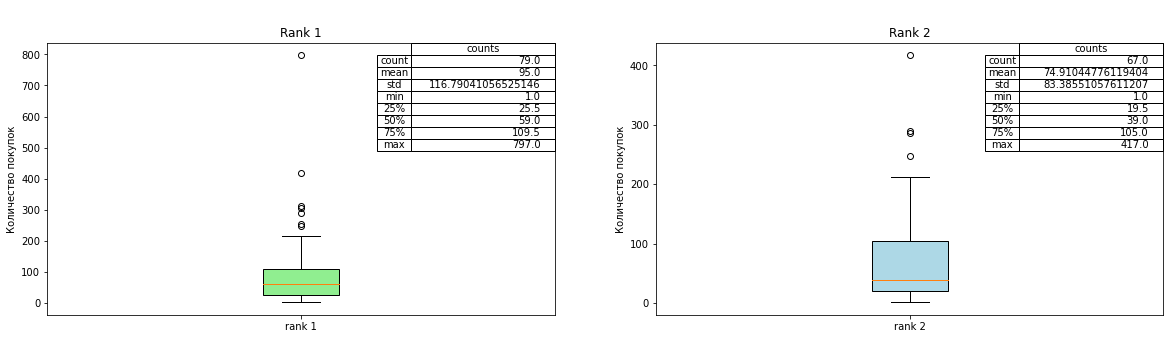

In [19]:
rank1_count_list = my_df[my_df['rank']==1]['count'].unique() # список уникальных количеств покупок для 1 и 2 рангов
rank2_count_list = my_df[my_df['rank']==2]['count'].unique()
summary1=pd.DataFrame(my_df[my_df['rank']==1]['count'].unique()).rename(columns={0:'counts'}).describe() # описательная статистика для 1 и 2 таблицы с уникальными количествами покупок для 1 и 2 рангов 
summary2=pd.DataFrame(my_df[my_df['rank']==2]['count'].unique()).rename(columns={0:'counts'}).describe()

fig, axes = plt.subplots(1, 2, figsize=(20,5)) # размещаем в одном пространстве 2 графика

bplot1 = axes[0].boxplot(rank1_count_list, # нарисуем на графике боксплот для таблицы количеств покупок первого ранга
                     vert=True,  
                     patch_artist=True,
                     labels=['rank 1'])   
axes[0].set_title('Rank 1') # добавим название графику 
axes[0].set_ylabel('Количество покупок') # добавим подпись к оси y
bplot1['boxes'][0].set_facecolor('lightgreen') # установим цвет для боксплота

# то же самое для таблицы второго ранга
bplot2 = axes[1].boxplot(rank2_count_list, 
                     vert=True,  
                     patch_artist=True,
                     labels=['rank 2']) 
axes[1].set_title('Rank 2') 
axes[1].set_ylabel('Количество покупок') 
bplot2['boxes'][0].set_facecolor('lightblue')

# рисуем дополнительный график с таблицей описательной статистики для первого боксплота
insert_axes1 = fig.add_axes([0.3778, 0.48, 0.1, 0.5]) # добавим дополнительный график к первому боксплоту
insert_axes1.axis("off") # убираем систему координат из графика
insert_axes1.table(cellText=summary1.values, # добавляем в график таблицу с описательной статистикой
          rowLabels=summary1.index,
          colLabels=summary1.columns,
          cellLoc = 'right', rowLoc = 'center',
          loc='center')
# рисуем дополнительный график с таблицей описательной статистики для второго боксплота
insert_axes2 = fig.add_axes([0.8, 0.48, 0.1, 0.5]) 
insert_axes2.axis("off") 
insert_axes2.table(cellText=summary2.values,
          rowLabels=summary2.index,
          colLabels=summary2.columns,
          cellLoc = 'right', rowLoc = 'center',
          loc='center')






Для первого ранга 25-й квантиль равен <b>25.5</b>, то есть 25% всех уникальных количеств покупок меньше чем 25.5. Мы можем отбросить эти 25% самых мелких количеств и в качестве минимальной границы количества покупок взять число 25.5. 

Аналогично поступим со вторым рангом: 
Тут 25-й квантиль равен <b>19.5</b>, то есть 25% всех уникальных количеств покуплк меньше 19.5. Это число будет минимальной границей для второго ранга.



Следующий вопрос на который нужно ответить - вместо такого малопопулярного курса необходимо выводить какой-то другой курс - какой? В этом случае можно показывать самые популярные курсы среди всех, ведь именно их пользователи покупают с большей вероятностью. 





In [20]:
courses_count_df = df.groupby('course_id')['course_id'].count()
courses_count_df = pd.DataFrame({'course_id':courses_count_df.index, 'count':courses_count_df.values})
the_most_popular_course = courses_count_df.sort_values(['count'], ascending=False).reset_index(drop = True).loc[0]
the_second_popular_course = courses_count_df.sort_values(['count'], ascending=False).reset_index(drop = True).loc[1]
print('Самый популярный курс')
print(the_most_popular_course)
print()
print('Второй по популярности курс')
print(the_second_popular_course)




Самый популярный курс
course_id     551
count        2935
Name: 0, dtype: int64

Второй по популярности курс
course_id     566
count        2342
Name: 1, dtype: int64


Приступим к замене наименее популярных рекомендаций наиболее популярными курсами: 




In [21]:
# сохраним нижнюю и верхнюю границу для каждого ранга в переменные
bottom_line1 = summary1.loc['25%'].values[0]
bottom_line2 = summary2.loc['25%'].values[0]

def replacement_recommendation(row): # функция, возвращающая самый популярный или второй по популярности id курса в зависимости от того, совпадает ли количество продаж с нижней границей или нет
    if row['rank']==1 and row['count']<bottom_line1:
        return the_most_popular_course['course_id']
    elif row['rank']==2 and row['count']<bottom_line2:
        return the_second_popular_course['course_id']
    else:
        return row['recommendation']
    
my_df['recommendation'] = my_df.apply(lambda row: replacement_recommendation(row), axis=1)  # заменим рекомендации с слишком маленьким количеством (<нижней границы) продаж на самые популярные курсы
my_df = my_df[['course_id', 'recommendation', 'rank']] # оставим только нужные нам столбцы
my_df



,course_id,recommendation,rank
0,1201.0,551.0,1.0
1,1201.0,551.0,1.0
2,1201.0,551.0,1.0
3,1201.0,551.0,1.0
4,1200.0,551.0,1.0
...,...,...,...
7797,358.0,566.0,2.0
7833,357.0,571.0,1.0
7834,357.0,356.0,2.0
7904,356.0,571.0,1.0


Как видно, непопулярные рекомендации заменились на самые популярные.



In [22]:
# Удалим лишние повторы 
my_df.drop_duplicates(subset = ['course_id', 'recommendation', 'rank'], keep = 'first', inplace = True)
my_df



,course_id,recommendation,rank
0,1201.0,551.0,1.0
4,1200.0,551.0,1.0
7,1199.0,551.0,1.0
8,1199.0,566.0,2.0
14,1198.0,551.0,1.0
...,...,...,...
7797,358.0,566.0,2.0
7833,357.0,571.0,1.0
7834,357.0,356.0,2.0
7904,356.0,571.0,1.0


Так как у одного курса может быть несколько самых популярных рекомендаций с одинаковым количеством продаж, но нам при этом нужно осавить только какую-то одну из них, то приходится выбирать - какую рекомендацию оставить, а какую убрать? 

Чтобы как-то продвигать менее популярные курсы можно оставлять ту рекомендацию, которая является наименее популярным курсом в общем рейтинге курсов. 

In [23]:
courses_with_several_rec = my_df[my_df.duplicated(subset=['course_id', 'rank'], keep=False)] # Для этого сначала посмотрим какие курсы имеют несколько одинаковых рекомендаций в одном ранге. Сохраним их в отдельную таблицу
minimum_rcmdtn_count_df = pd.DataFrame(columns=['course_id', 'recommendation', 'rank']) # создадим датафрейм для записи данных только с одной рекомендацией для каждого курса в одном ранге

for current_rank in [1,2]:
    
    for i in courses_with_several_rec[courses_with_several_rec['rank']==current_rank].index: # цикл по строкам таблицы курсов с несколькими рекомендациями в одном ранге
        current_course_id = courses_with_several_rec.loc[i, 'course_id'] # переменная для хранения текущего ай ди курса 
        counts_dict = {} # временный словарь для записи данных о рекомендации к курсу и количестве покупок этой рекомендации в общей таблице курсов
        recommendations_list = courses_with_several_rec[(courses_with_several_rec['course_id']==current_course_id)&(courses_with_several_rec['rank']==current_rank)]['recommendation'].to_list() # список со всеми рекомендациями текущего курса в одном ранге
        
        for item in recommendations_list: # проходимся по этому списку для того, чтобы определить, какой из этих курсов имеет минимальное количество покупок 
            counts_dict[item] = courses_count_df[courses_count_df['course_id']==item]['count'].values[0] # записываем во временный словарь курс и кол-во его покупок
        
        rcmd_with_min_count = min(counts_dict, key=counts_dict.get) # Находим курс с минимальным количеством покупок. Эта функция выводит первый ключ с минимальным значением - это то что нам нужно. Так как в случае одинакового минимального количества покупок нам нет разницы какую рекомендацию брать.
        minimum_rcmdtn_count_df.loc[i] = [current_course_id, rcmd_with_min_count, current_rank] # сохраняем строки с нужными нам рекомендациями в датафрейм
           
        
        
minimum_rcmdtn_count_df.drop_duplicates(subset = ['course_id', 'recommendation', 'rank'], keep = 'first', inplace = True) # удаляем лишние строки в новой получившейся таблице  
my_df = my_df[~my_df.index.isin(courses_with_several_rec.index)] # убираем из нашей основной таблицы строки где курсы, имеют несколько одинаковых рекомендаций в одном ранге
my_df = my_df.append(minimum_rcmdtn_count_df, sort = False, ignore_index=True)  # прибавляем к основной таблице строки из новой таблицы с удаленными ненужными строками и получаем желаемый результат
my_df        
        
        
        
    




,course_id,recommendation,rank
0,1201.0,551.0,1.0
1,1200.0,551.0,1.0
2,1199.0,551.0,1.0
3,1199.0,566.0,2.0
4,1198.0,551.0,1.0
...,...,...,...
243,791.0,664.0,2.0
244,777.0,523.0,2.0
245,757.0,490.0,2.0
246,742.0,513.0,2.0


Изменим таблицу на требуемый в задаче вид: 
- 1 столбец: id курса к которому идет рекомендация
- 2 столбец: 1-я рекомендация (самая популярная)
- 3 столбец: 2-я рекомендация (вторая по популярности)

In [24]:
my_df_1 = my_df[my_df['rank']==1][['course_id', 'recommendation']].rename(columns={'recommendation':'recommendation 1'}) # таблица со столбцом рекомендации 1 
my_df_2 = my_df[my_df['rank']==2][['course_id', 'recommendation']].rename(columns={'recommendation':'recommendation 2'}) # таблица со столбцом рекомендации 2
my_df = my_df_1.merge(my_df_2, how='outer', on='course_id') # соединем эти две таблицы и получаем таблицу, в котором в первом столбце id курса, во втором первая рекомендация, а в третем вторая рекомендация
my_df



,course_id,recommendation 1,recommendation 2
0,1201.0,551.0,NaN
1,1200.0,551.0,NaN
2,1199.0,551.0,566.0
3,1198.0,551.0,566.0
4,1188.0,551.0,566.0
...,...,...,...
121,357.0,571.0,356.0
122,356.0,571.0,357.0
123,1141.0,742.0,566.0
124,1099.0,568.0,553.0


- В получившейся таблице существуют курсы, у которых вообще нет второй рекомендации. Это могло произойти по двум причинам: 
    - Курс изначально покупали только в паре с одним курсом. 
    - Курс покупали в паре с несколькими курсами, но все покупки были по одному разу. Ранее при проставлении ранга к таким курсам везде проставился ранг 1, так как количество везде было одинаковое равное 1. После чего мы для каждого конкретного ранга (для 1 или для 2) заменяли малопопулярную рекомендацию на наиболее популярные курсы. Так как у некоторых курсов не существовало второго ранга, вторая рекомендация тоже не проставилась. Поэтому у этих курсов нет второй рекомендации. 
  
  В этом случае просто созданим ему вторую рекомендацию в виде одного из самых популярных курсов (1-й по популярности, если существующая рекомендация с первым рангом не равна этому курсу, и 2-й по популярности, если существующая рекомендация с первым рангом уже равна 1-му по популярности курсу)
  
  
- В начале мы избавились от одного курса, так как у него не было ни одной успешной покупки. Пришла пора добавить его в таблицу и дать рекомендации к нему - это будут два самых популярных курса. 





In [25]:
# посмотрим есть ли курсы у которых нет первой рекомендации 
my_df[my_df['recommendation 1'].isnull()]



,course_id,recommendation 1,recommendation 2


Их нет.

In [26]:
# посмотрим на курсы у которых нет второй рекомендации 
courses_withaut_second_rec = my_df[my_df['recommendation 2'].isnull()]
courses_withaut_second_rec


,course_id,recommendation 1,recommendation 2
0,1201.0,551.0,NaN
1,1200.0,551.0,NaN
9,1182.0,551.0,NaN
38,902.0,551.0,NaN


In [27]:
def to_add_the_second_recommendation(row): # функция для добавления второй рекомендации, если она отсутствует
    if row['course_id'] in set(courses_withaut_second_rec['course_id']): # если у курса нет второй рекомендации,
        if row['recommendation 1']==the_most_popular_course['course_id']: # если первая рекомендация у такого курса равна самому популярному курсу
            return the_second_popular_course['course_id'] # то в качестве второй рекомендации возвращаем второй по популярности курс
        else: # во всех остальных случаях
            return the_most_popular_course['course_id'] # в качестве второй рекомендации возвращаем самый популярный курс
    else:  # в противном случае, если у курса уже есть вторая рекомендация, то
        return row['recommendation 2'] # ничего не менеям и возвращаем существующую вторую рекомендацию
    
    
my_df['recommendation 2'] = my_df.apply(lambda row: to_add_the_second_recommendation(row), axis=1)  
my_df



,course_id,recommendation 1,recommendation 2
0,1201.0,551.0,566.0
1,1200.0,551.0,566.0
2,1199.0,551.0,566.0
3,1198.0,551.0,566.0
4,1188.0,551.0,566.0
...,...,...,...
121,357.0,571.0,356.0
122,356.0,571.0,357.0
123,1141.0,742.0,566.0
124,1099.0,568.0,553.0


Вторая рекомендация теперь есть у каждого курса.

Теперь добавим отсутствующие курсы, которые ни разу не продали, и добавим к нему рекомендации (мы знаем, что такой курс только один (127 course_id)). 



In [28]:
a=[]
for x in set(all_courses)-set(my_df['course_id']):
    a.append(x)

new_df = pd.DataFrame(columns=['course_id', 'recommendation 1', 'recommendation 2'])
new_df['course_id'] = a
new_df['recommendation 1'] = the_most_popular_course['course_id']
new_df['recommendation 2'] = the_second_popular_course['course_id']
my_df = my_df.append(new_df, sort = False, ignore_index=True)




<a id='1.3'></a>
## 1.3 Вывод результата и итоги

In [29]:
my_df.to_csv('course_recommendations.csv', index = False)

my_df


,course_id,recommendation 1,recommendation 2
0,1201.0,551.0,566.0
1,1200.0,551.0,566.0
2,1199.0,551.0,566.0
3,1198.0,551.0,566.0
4,1188.0,551.0,566.0
...,...,...,...
122,356.0,571.0,357.0
123,1141.0,742.0,566.0
124,1099.0,568.0,553.0
125,756.0,566.0,552.0


Итак, задача выполнена, и мы составили таблицу, где каждому ID курса дается две рекомендации: 
- recommendation 1 - самый популярный курс
- recommendation 2 - второй по популярности курс


Принцип подбора подходящей рекомендации в recommendation 1: 
- Этот курс чаще всего покупали вместе с курсом, которому дается рекомендация. 
- Количество покупок курса вместе с его рекомендацией слишком мало, поэтому мы не учитываем такие рекомендации. В этом случае в качестве рекомендации устанавливается самый популярный курс из всех. 
- В случае если у курса, которому дается рекомендация, существует несколько самых популярных рекомендаций с одинаковым количеством покупок, мы оставляем только ту рекомендацию, которая вляется наименее популярным курсом среди всех курсов. Мы ничего не теряем, так как вероятность того, что пользователь добавит любую из этих рекомендаций в корзину одинакова. При этом предполагается, что это позволит продвинуть менее популярные курсы. 


Принцип подбора подходящей рекомендации в recommendation 2 аналогичен, только здесь мы смотрим на вторые по популярности курсы, а не на самые популярные. 





<a id='2'></a>
# 2. A/B тестирование 

## 2.1 Описание, ход работы и обработка результатов эксперимента


Спустя месяц на сайте реализована новая функциональность с предложением добавить в корзину второй подходящий курс. На данном этапе необходимо оценить эффективность этой функции и качество подбора рекомендаций.

Для этого запустим сплит-тест, где все клиенты случайным образом делятся на контрольную и тестовую группы. Тестовой группе показываются рекомендации, а контрольной — нет.


1. <b>Задачи A/B тестирования</b>

    Предполагается, что новая функция с рекомендателной системой повысит количество клиентов, купивших более одного курса в рамках одной корзины. Для проверки этого предположения мы проведем A/B тестирование. 


2. <b>Определение метрики </b>

    Чтобы понять каким образом изменилось количество клиентов, купивших более одного курса после введения это функции, в ходе A/B тестирования мы будем смотреть на <b>среднюю конверсию в покупку второго курса</b>, рассчитанную как количество клиентов, купивших более одного курса, поделенное на общее количество клиентов, оформивших заказ. 


3. <b>Постановка гипотезы</b>

    Ожидается, что ввод рекомендаций сможет увеличить среднюю конверсию в покупку второго курса.
    
    Для того, чтобы понять, будет ли наблюдаемая разница в конверсиях между контрольной и тестовой группой случайностью или результатом нововведений на платформе, определим две противоположные гипотезы: 
    
    - H0: Выборочная конверсия в покупку второго курса в контрольной группе такая же как выборочная конверсия в тестовой группе: 
        - Pc - Pt = 0 или 
        - Pc = Pt
 
    - H1: Выборочная конверсия в покупку второго курса в тестовой группе больше чем выборочная конверсия в покупку второго курса в контрольной группе: 
        - Pc - Pt < 0 или 
        - Pc < Pt 
        
где 
- Pc - это истинная конверсия в контрольной группе;
- Pt - это истинная конверсия в тестовой группе

        
        
        
        
4. <b>Подготовка к эксперименту</b>
    - <b>Определение контрольной и тестовой группы</b>.
        Как было сказано выше все клиенты случайным образом делятся на контрольную и тестовую группы. Тестовой группе показываются рекомендации, а контрольной — нет.
    - <b>Уровень значимости (Significance level) α = 5%</b>. Это уровень риска, который мы принимаем
        при ошибках первого рода (отвержение нулевой гипотезы, когда на самом деле она верна). 
    - <b>Мощность теста (Statistical power) 1 - β = 80%</b>. Это вероятность отклонения нулевой гипотезы, когда она ложна, т.е. это шанс обнаружить положительный эффект от введения рекомендательной системы как статистически значимый. В идеале хотелось бы, чтобы мощность критерия составляла 100%, однако это невозможно, так как всегда остается шанс, хотя и незначительный, допустить ошибку 2-го рода β (когда нулевую гипотезу не отвергают, когда она на самом деле ложна). 
    - <b>Базовая конверсия (Baseline conversion rate - BCR) = 3.2%</b>. До реализации рекомендаций средняя конверсия в покупку второго курса была 3.2%.
    - <b>Минимальная желаемая разница в конверсии (Minimum Detectable Effect - MDE) = 0.8%</b>. Ожидается, что ввод рекомендаций сможет поднять базовую конверсию хотя бы до 4%. Таким образом, MDE = 4-3.2 = 0.8. 
    - <b>Минимальный размер выборки для каждой группы = 7866</b>. Наличие достаточно большого размера выборки важно для обеспечения статистически значимых результатов теста. С помощью калькулятора https://www.evanmiller.org/ab-testing/sample-size.html мы определили минимальный размер выборки для проведения теста при уровне значимости α = 5%, мощности теста 1 - β = 80%, BCR = 3.2% и MDE = 0.8%. 
    
    
5. <b>Наблюдения</b>

    Прошло три недели, и каждый из вариантов сплит-теста достиг минимального необходимого размера выборки.

    Результаты:

    - В контрольной группе оказалось 8732 клиента, оформивших заказ, из них 293 купили больше одного курса. 
        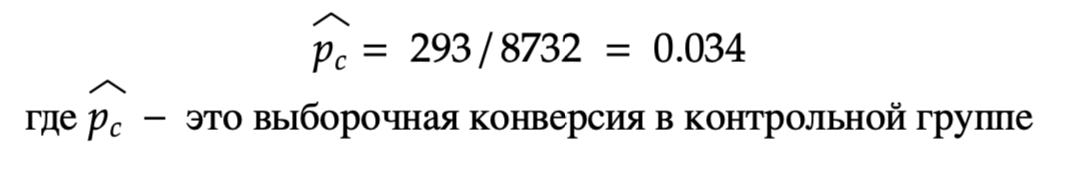
   

    - В тестовой — 8847 клиентов, из них 347 купили больше одного курса.
    
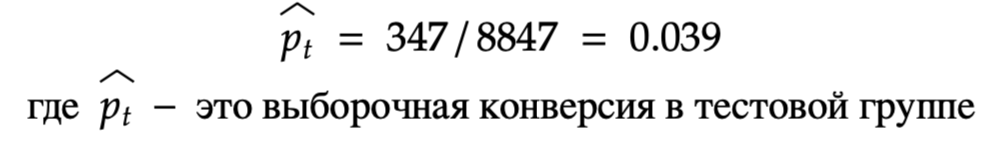

        
6. <b>Проанализируем полученные результаты и рассчитаем значимость изменения конверсии</b> 

    <b>Если гипотеза H0 верна</b>, тогда разность выборочных конверсий (или по-другому выборочных пропорций)   распределена нормально (по ЦПТ при достаточно большом n выборки пропорция распределена нормально). 
    
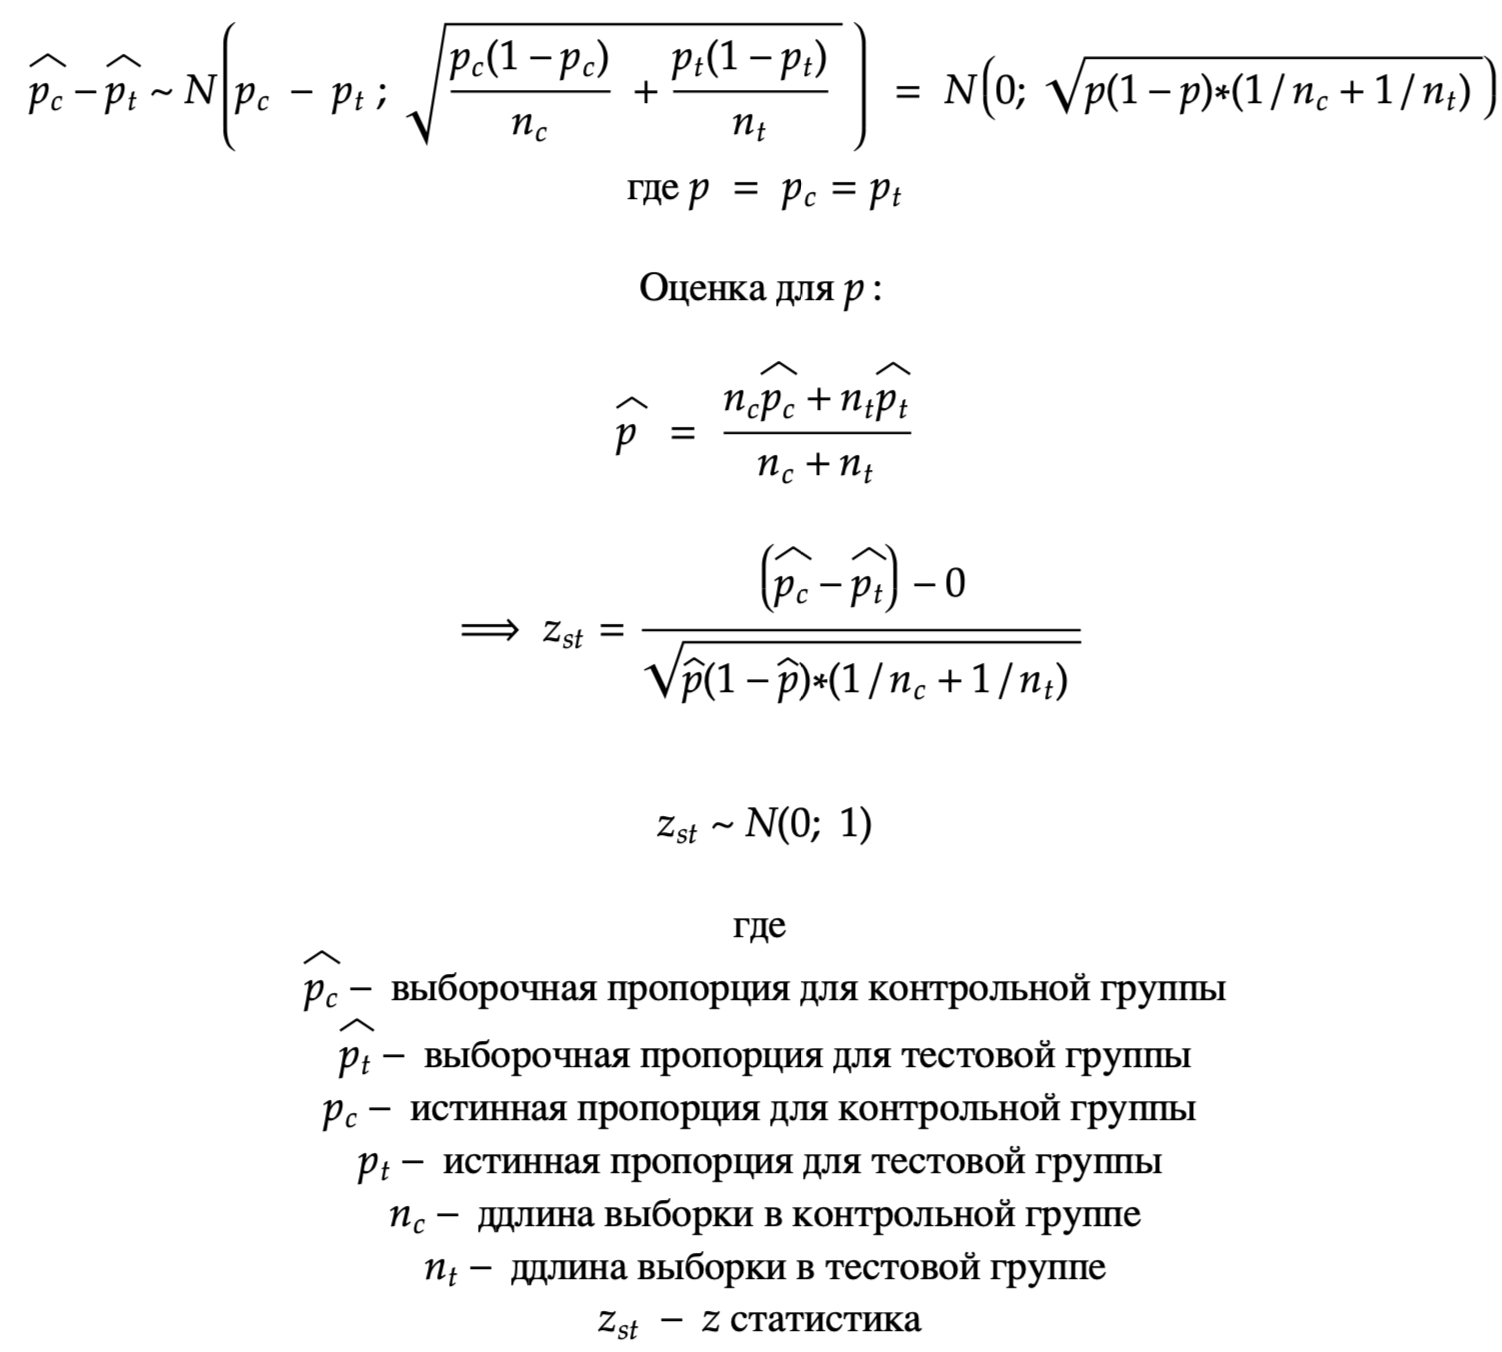
    
    
    

    









In [30]:
# размер выборки
n_c = 8732 
n_t = 8847
# выборочные конверсии
сonversion_control = 293/n_c
сonversion_test = 347/n_t

p = (n_c*сonversion_control+n_t*сonversion_test)/(n_c+n_t) # оценка для истинной пропорции 

z_st = (сonversion_control-сonversion_test)/(math.sqrt(p*(1-p)*(1/n_c+1/n_t))) # z статистика
p_val = norm.cdf(z_st) # p-value 


print(' z статистка =', round(z_st,3), '\n', 'p-value =', round(p_val,3), '\n', 'Конверсия в контрольной группе =', round(сonversion_control, 3), '\n', 'Конверсия в тестовой группе =', round(сonversion_test,3), '\n', 'Разнаца в конверсии =', round(сonversion_test-сonversion_control, 3))




 z статистка = -2.006 
 p-value = 0.022 
 Конверсия в контрольной группе = 0.034 
 Конверсия в тестовой группе = 0.039 
 Разнаца в конверсии = 0.006


Построим график распределения конверсий для тестовой и контрольной групп, выделим истинное математическое ожидание и критическое значение при альфа = 5%, посчитаем доверительные интервалы. 

In [31]:
# средние значение двух распределений
mu_c = 293/n_c
mu_t = 347/n_t
# стандартные отклонения двух распределений
s_c = math.sqrt((mu_c*(1-mu_c))/n_c)
s_t = math.sqrt((mu_t*(1-mu_t))/n_t)
a = 0.05
          
# критическое значение при a = 5% 
c = stats.norm.ppf(0.95, loc=mu_c, scale=s_c)

# функция для вычисления доверительного интервала для пропорции
def confidence_internal_p_norm(p, alpha, n):
    value = -norm.ppf(alpha/2) * math.sqrt((p*(1-p))/n)
    return p-value, p+value

# доверительные интервалы 
interv_c = confidence_internal_p_norm(mu_c, a, n_c)
interv_t = confidence_internal_p_norm(mu_t, a, n_t)
print("Доверительный интервал конверсии в контрольной группе: {}".format(interv_c) )
print("Доверительный интервал конверсии в тестовой группе: {}".format(interv_t) )



Доверительный интервал конверсии в контрольной группе: (0.02977765578415755, 0.0373318265795621)
Доверительный интервал конверсии в тестовой группе: (0.03517724468107354, 0.043267425828703784)


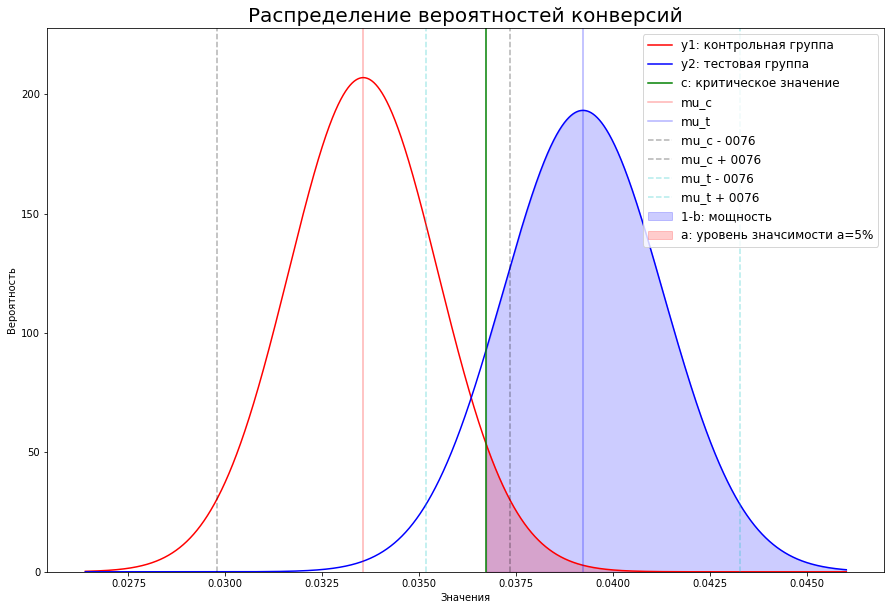

In [32]:
# отрисовка графика распределения конверсий 

support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(support, y1, color='r', label='y1: контрольная группа')
ax.plot(support, y2, color='b', label='y2: тестовая группа')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: критическое значение')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='-', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='-', label='mu_t')

ax.axvline(interv_c[0], color='k', alpha=0.3, linestyle='--', label='mu_c - 0076')
ax.axvline(interv_c[1], color='k', alpha=0.3, linestyle='--', label='mu_c + 0076')
ax.axvline(interv_t[0], color='c', alpha=0.3, linestyle='--', label='mu_t - 0076')
ax.axvline(interv_t[1], color='c', alpha=0.3, linestyle='--', label='mu_t + 0076')


ax.fill_between(support[support >= c], 
                y2[support >= c], 
                color='b', alpha=0.2, label='1-b: мощность')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: уровень значсимости а=5%')

ax.legend(loc='upper right', prop={'size': 12})
ax.set_title('Распределение вероятностей конверсий', fontsize=20)
ax.set_xlabel('Значения')
ax.set_ylabel('Вероятность')

plt.show()





<a id='2.2'></a>
## 2.2 Результат A/B тестирования

- Конверсия в контрольной группе = 0.034 
- Конверсия в тестовой группе = 0.039 
- Разнаца в конверсии = 0.006

- Доверительный интервал конверсии в контрольной группе: (0.02977765578415755, 0.0373318265795621)
- Доверительный интервал конверсии в тестовой группе: (0.03517724468107354, 0.043267425828703784)

- z статистка = -2.006 
- α = 0.05
- p-value = 0.022
- p-value < α => H0 отвергается в пользу H1

<b>z статистика</b> по модулю показывает на сколько стандартных отклонений выборочная конверсия отклоняется от предполагаемой и ожидаемой истинной конверсии. Если предположить, что H0 верна, то чем больше z ст. по модулю, тем более неправдоподобной нам кажется оцененное значение выборочной конверсии. В данном случае мы получили z ст. по модулю равным 2, то есть если H0 верна, то наблюдаемая разница выборочных пропорций 0.006 отклонилось от ожидаемой разници конверсий (=0) на больше, чем 2 стандартных отклонения, что довольно далеко от ожиданий. 

Достаточно ли это далеко для того, чтобы отвергнуть H0? Для этого мы посчитали p-value, которое обозначает вероятность появления нашей оцененной разницы выборочных конверсий при условии, что H0 верна. В нашем случае <b>p-value = 0.022 (2.2%)</b> - это вероятность того, что при условии равенства истинных конверсий в контрольной и тестовой группахв в ходе эксперимента мы могли получить разницу выборочных конверсий = 0.06. 


p-value = 0.022 (2.2%) - слишком маленькая вероятность, чтобы мы могли подтвердить нулевую гипотезу, ведь она меньше, чем установленный изначально уровень значимости α = 0.05 (5%)

<b>Вывод</b>: 

Таким образом, мы отвергаем H0 в пользу H1 и считаем, что полученные в ходе эксперимента результаты показали статистически значимые результаты. В 5% случаев мы можем ошибиться, но зато мы уверены на 80% в том, что получили действительно статистически значимые результаты. Это позволяет нам говорить о фактическом, но небольшом увеличении средней конверсии в покупку второго курса после запуска системы рекомендаций (было 3.3%, стало 3.9%, разница в конверсии составляет 0.6%). А если рекомендательная система работает, то с ее помощью на платформе будут также продвигаться не самые популярные курсы, которые обычно покупают пользователи. Конечно, разница совсем не большая, но она есть,  поэтому имеет смысл запустить эту функцию для всех клиентов SkillFactory. 
